In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

In [2]:
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

In [3]:
import torch.distributions as tdist

In [4]:
pointCount = 10
points = generateData.samplePoints(pointCount=pointCount).detach()

/Users/alaignelet/Documents/08_PhD/pde_project/optimal_control/pde.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  xPoint = torch.tensor( xPoint, requires_grad=True )[:, :, 0].T.float()


In [5]:
adjacent_points = []
for center_point in points:
    n = tdist.Normal(center_point, torch.tensor(0.1))
    adjacent_points.append( n.sample((3,)) )

adjacent_points = torch.cat(adjacent_points)

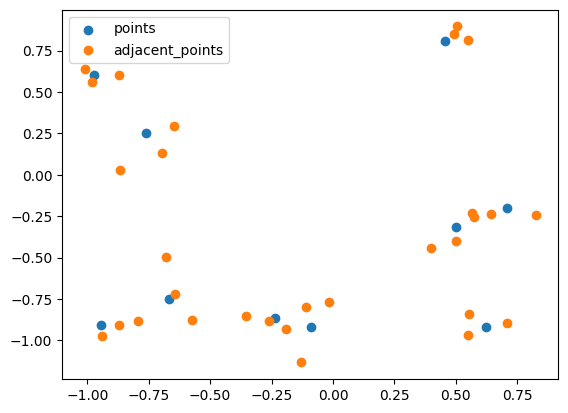

In [6]:
fig, ax = plt.subplots()
ax.scatter( points[:, 0], points[:, 1], label='points' )
ax.scatter( adjacent_points[:, 0], adjacent_points[:, 1], label='adjacent_points' )
ax.legend();

In [7]:
import networkx as nx

# Try the manifold regularisation without the data augmentation

In [29]:
# Build matrix of distances between particles
from turtle import distance
from scipy.spatial.distance import cdist
distMatrix = np.round( cdist(points, points, lambda u, v: np.exp((-(u-v)).sum())), 2 )
distMatrix.shape

(10, 10)

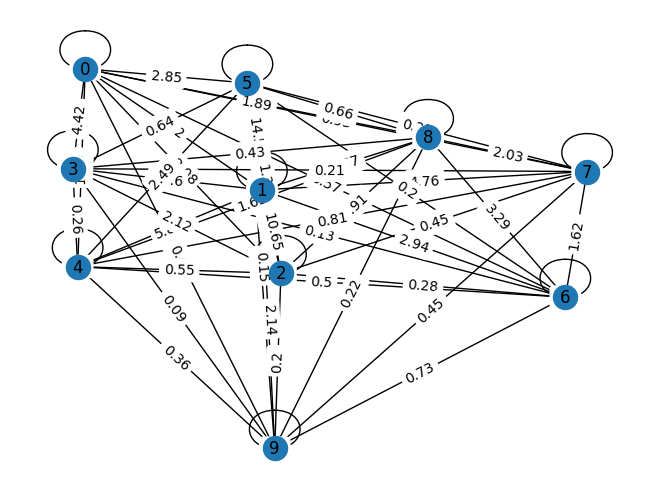

In [30]:
G = nx.Graph()
G = nx.from_numpy_matrix(distMatrix, create_using=nx.Graph)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

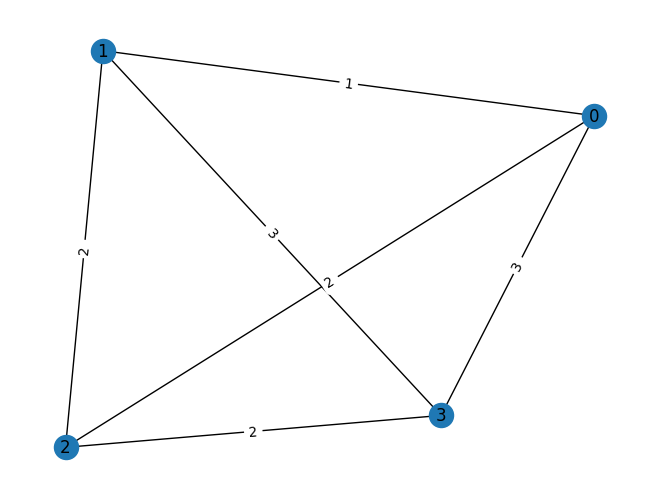

In [25]:
G = nx.Graph()
A = np.array([[0,1,2,3],
              [1,0,2,3],
              [2,2,0,2],
              [3,3,2,0]])
G = nx.from_numpy_matrix(A, create_using=nx.Graph)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

In [18]:
# Build matrix of distances between particles
from scipy.spatial.distance import cdist
distMatrix = cdist(points, adjacent_points)
distMatrix

array([[0.05627963, 0.09952351, 0.03967517, 1.53512093, 1.48263419,
        1.50503366, 1.64191144, 1.58252672, 1.64415294, 1.51458472,
        1.57569148, 1.49217686, 0.54660167, 0.4451399 , 0.58069233,
        1.5313734 , 1.36384446, 1.13514976, 1.71962093, 1.74922467,
        1.77889194, 2.18402456, 2.24947107, 2.09739566, 1.66891701,
        1.92691918, 1.72112614, 1.76791579, 1.98381727, 1.81966173],
       [1.4745016 , 1.34148993, 1.45680102, 0.09487681, 0.05466074,
        0.1016771 , 1.83382551, 1.84862674, 1.70257363, 2.1690485 ,
        2.26360105, 2.09824467, 1.335274  , 1.21397697, 1.53272556,
        1.97308229, 1.88345367, 1.72949492, 1.24963123, 1.04704727,
        1.20846415, 1.77727221, 1.72089438, 1.65025734, 1.64401281,
        2.02799336, 1.85824748, 1.07145722, 1.11421021, 1.06099917],
       [1.69347239, 1.60083508, 1.61069197, 1.8577092 , 1.86289854,
        1.91212463, 0.02836889, 0.11486297, 0.14541572, 0.63339837,
        0.71162941, 0.55401478, 1.09503776, 1.

In [201]:
# we may want to use a threshold on the distance too? Or maybe just sample closer to each point..
(( distMatrix < 0.5 ) * 1 ).sum()

116

# Example with real Neural network

In [212]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

gamma_adjacent = 0*1e-1
pointCount = 11
generateData = GenerateData(domain=([-1, 1], [-1, 1]))

lrs = [1e-2, 1e-3, 1e-4]
iterations = [1000, 2000, 4000]

In [213]:
np.random.seed(0)
xData = generateData.samplePoints(pointCount=pointCount)
xAdjacentData = generateData.samplePoints(pointCount=pointCount)
xEvaluation = generateData.sampleGrid(nPoint=100)

yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []


# we compute the matrix based on the x's, en evaluate the loss with the y's
distMatrix = cdist(xData.detach().numpy(), xAdjacentData.detach().numpy())

# take the inverse of the distance
# distMatrix = 1. / distMatrix

# or apply a threshold
distMatrix = ( distMatrix < 0.2 ) * 1
print(distMatrix.sum())

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        yData = network.computeValueFunction(xData)
        yAdjacentData = network.computeValueFunction(xAdjacentData)
        
        # compute loss and backpropagate
        lossData = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        lossAdjacent = ( ( yData - yAdjacentData.T )**2 * torch.tensor(distMatrix).float() ).sum()

        loss = lossData + gamma_adjacent * lossAdjacent

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()


        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

5
0 / 7000 (0 / 1000), lr:1.0e-02, loss:1.87e-02
100 / 7000 (100 / 1000), lr:1.0e-02, loss:1.38e-02
200 / 7000 (200 / 1000), lr:1.0e-02, loss:1.36e-02
300 / 7000 (300 / 1000), lr:1.0e-02, loss:1.08e-02
400 / 7000 (400 / 1000), lr:1.0e-02, loss:9.60e-04
500 / 7000 (500 / 1000), lr:1.0e-02, loss:8.78e-04
600 / 7000 (600 / 1000), lr:1.0e-02, loss:8.08e-04
700 / 7000 (700 / 1000), lr:1.0e-02, loss:6.93e-04
800 / 7000 (800 / 1000), lr:1.0e-02, loss:5.10e-04
900 / 7000 (900 / 1000), lr:1.0e-02, loss:2.94e-04
1000 / 7000 (0 / 2000), lr:1.0e-03, loss:1.39e-04
1100 / 7000 (100 / 2000), lr:1.0e-03, loss:1.20e-04
1200 / 7000 (200 / 2000), lr:1.0e-03, loss:9.83e-05
1300 / 7000 (300 / 2000), lr:1.0e-03, loss:8.09e-05
1400 / 7000 (400 / 2000), lr:1.0e-03, loss:6.81e-05
1500 / 7000 (500 / 2000), lr:1.0e-03, loss:5.85e-05
1600 / 7000 (600 / 2000), lr:1.0e-03, loss:5.10e-05
1700 / 7000 (700 / 2000), lr:1.0e-03, loss:4.47e-05
1800 / 7000 (800 / 2000), lr:1.0e-03, loss:3.93e-05
1900 / 7000 (900 / 2000), 

In [214]:
xData[:2]

tensor([[0.0976, 0.0578],
        [0.4304, 0.1361]], grad_fn=<SliceBackward>)

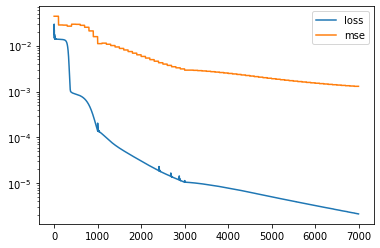

In [215]:
fig, ax = plt.subplots()
info['loss'].plot(ax=ax)
info['mse'].plot(ax=ax)
ax.set_yscale('log')
ax.legend();

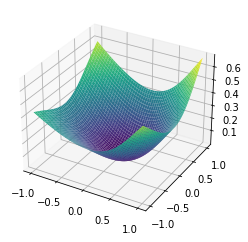

In [216]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Reference

In [233]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)

gamma = {'matrix':0, 'residual':1, 'data':0, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

In [234]:
lrs = [1e-1, 1e-2]
iterations = [500, 1000]

resu = lqr.train(interiorPointCount=100, dataPointCount=1, lrs=lrs, iterations=iterations, useTestData=False, verbose=True)

xInt:  torch.Size([100, 2])
xData:  torch.Size([1, 2])
0 / 1500 (0 / 500), lr:1.0e-01, loss:1.27e-01 (data: 0.00e+00, grad: 0.00e+00, res: 1.27e-01, mat: 0.00e+00)
100 / 1500 (100 / 500), lr:1.0e-01, loss:3.23e-02 (data: 0.00e+00, grad: 0.00e+00, res: 3.23e-02, mat: 0.00e+00)
200 / 1500 (200 / 500), lr:1.0e-01, loss:1.47e-03 (data: 0.00e+00, grad: 0.00e+00, res: 1.47e-03, mat: 0.00e+00)
300 / 1500 (300 / 500), lr:1.0e-01, loss:4.69e-04 (data: 0.00e+00, grad: 0.00e+00, res: 4.69e-04, mat: 0.00e+00)
400 / 1500 (400 / 500), lr:1.0e-01, loss:3.38e-04 (data: 0.00e+00, grad: 0.00e+00, res: 3.38e-04, mat: 0.00e+00)
500 / 1500 (0 / 1000), lr:1.0e-02, loss:6.45e-05 (data: 0.00e+00, grad: 0.00e+00, res: 6.45e-05, mat: 0.00e+00)
600 / 1500 (100 / 1000), lr:1.0e-02, loss:3.83e-05 (data: 0.00e+00, grad: 0.00e+00, res: 3.83e-05, mat: 0.00e+00)
700 / 1500 (200 / 1000), lr:1.0e-02, loss:2.85e-05 (data: 0.00e+00, grad: 0.00e+00, res: 2.85e-05, mat: 0.00e+00)
800 / 1500 (300 / 1000), lr:1.0e-02, loss:1.

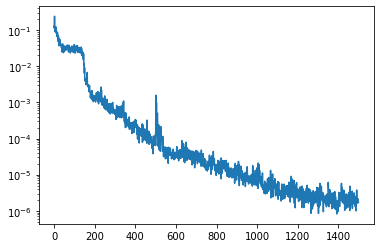

In [235]:
plt.plot( resu['loss'] )
plt.yscale('log')

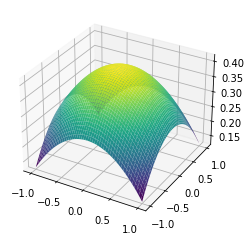

In [236]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = lqr.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');